In [1]:
# uncomment it if use colab
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 14.7 MB/s 


In [23]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import keras as ks
import tensorflow as tf
import pickle
from tensorflow.keras.layers import Activation, Flatten, Dense, Reshape, Input, Dot, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import keras
import random
import os
import zipfile
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# **Loading the Dataset**

In [4]:
# uncomment it if on colab
# data_path = os.path.join("drive", "MyDrive", "Data.zip") 
# with zipfile.ZipFile(data_path, 'r') as zip_ref:
#     zip_ref.extractall("")

In [6]:
train_path = os.path.join("Data", "train_data")
test_path = os.path.join("Data", "test_data")

In [7]:
chars = os.listdir(train_path)
chars2index = {chars[i]:i for i in range(len(chars))}
index2chars = {v: k for k, v in chars2index.items()}
index2chars[0]

'仟'

In [58]:
print("There are",len(index2chars), "characters/classes.")

There are 200 characters/classes.


In [9]:
def create_data_set(path, chars, img_size):

    if 'train' in path:
      print("Start collecting data for train set.")
    elif 'test' in path:
      print("Start collecting data for test set.")
    df_x = []
    df_y = []
    for char in chars:
      image_names = os.listdir(os.path.join(path, char))
      for image_name in image_names:
        image = load_img(os.path.join(path, char, image_name), target_size=img_size)
        img_array = img_to_array(image) 
        df_x.append(img_array)
        df_y.append(chars2index[char])
    print('Data collection finished.')
    return np.stack(df_x), np.array(df_y)

In [10]:
img_size = (16, 16, 3)

In [11]:
X_train, y_train = create_data_set(train_path, chars, img_size)
X_test, y_test = create_data_set(test_path, chars, img_size)

Start collecting data for train set.
Data collection finished.
Start collecting data for test set.
Data collection finished.


In [12]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(103548, 16, 16, 3) (103548,)
(24791, 16, 16, 3) (24791,)


In [13]:
# Normalizing and flattening
X_train = X_train.astype('float32')
X_train /= 255
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) # flatten
X_test = X_test.astype('float32')
X_test /= 255
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:]))) # flatten

In [14]:
X_train.shape

(103548, 768)

In [15]:
y_train.shape

(103548,)

# **Making Pairs for One Shot Learning**

In [16]:
class Pairs:
  def makePairs(self, x, y):
    num_classes = 200
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = list()
    labels = list()

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        labels += list([1])
        pairs += [[x1, x2]]
    
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        labels += list([0])
        pairs += [[x1, x2]]
        
    return np.array(pairs), np.array(labels)

In [17]:
p = Pairs()

In [18]:
pairs_train, labels_train = p.makePairs(X_train, y_train)
pairs_test, labels_test = p.makePairs(X_test, y_test)
labels_train = labels_train.astype('float32')
labels_test = labels_test.astype('float32')

# **Siamese Network**

In [27]:
def euclideanDistance(v):
    x, y = v
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_original, y_pred):
    sqaure_pred = K.square(y_pred)
    margin = 1
    margin_square = K.square(K.maximum(0., margin - y_pred))
    return K.mean(y_original * sqaure_pred + (1 - y_original) * margin_square)

def compute_accuracy(y_original, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_original)

def accuracy(y_original, y_pred):
    return K.mean(K.equal(y_original, K.cast(y_pred < 0.5, y_original.dtype)))

In [32]:
input = Input(shape=(X_train.shape[1],))
x = Flatten()(input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
dense = Model(input, x)

input1 = Input(shape=(X_train.shape[1],))
input2 = Input(shape=(X_train.shape[1],))
dense1 = dense(input1)
dense2 = dense(input2)

distance = Lambda(euclideanDistance, output_shape=eucl_dist_output_shape)([dense1, dense2])
model = Model([input1, input2], distance)

# **Contrastive loss**

In [33]:
model.compile(loss = contrastive_loss, optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 model_4 (Functional)           (None, 256)          90560       ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 1)            0           ['model_4[0][0]',          

In [34]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=30, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/30
1618/1618 [==============================] - 8s 5ms/step - loss: 0.2012 - accuracy: 0.6891 - val_loss: 0.1998 - val_accuracy: 0.6911
Epoch 2/30
1618/1618 [==============================] - 7s 4ms/step - loss: 0.1860 - accuracy: 0.7227 - val_loss: 0.1976 - val_accuracy: 0.6991
Epoch 3/30
1618/1618 [==============================] - 7s 4ms/step - loss: 0.1803 - accuracy: 0.7341 - val_loss: 0.1863 - val_accuracy: 0.7209
Epoch 4/30
1618/1618 [==============================] - 7s 4ms/step - loss: 0.1769 - accuracy: 0.7415 - val_loss: 0.1858 - val_accuracy: 0.7197
Epoch 5/30
1618/1618 [==============================] - 7s 4ms/step - loss: 0.1737 - accuracy: 0.7485 - val_loss: 0.1813 - val_accuracy: 0.7294
Epoch 6/30
1618/1618 [==============================] - 7s 4ms/step - loss: 0.1711 - accuracy: 0.7531 - val_loss: 0.1805 - val_accuracy: 0.7287
Epoch 7/30
1618/1618 [==============================] - 7s 4ms/step - loss: 0.1697 - accuracy: 0.7558 - val_loss: 0.1776 - val_accuracy:

In [35]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [38]:
print("Accuracy on test set:", te_acc*100, "%.")

Accuracy on test set: 74.76705255939655 %.


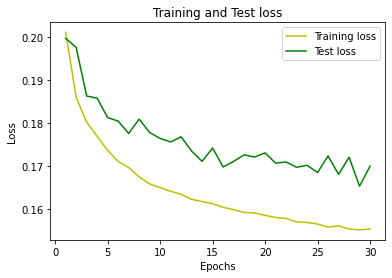

In [39]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Triplet Loss**

In [46]:
input = Input(shape=(X_train.shape[1],))
x = Flatten()(input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
dense = Model(input, x)

input1 = Input(shape=(X_train.shape[1],))
input2 = Input(shape=(X_train.shape[1],))
dense1 = dense(input1)
dense2 = dense(input2)

distance = Lambda(euclideanDistance, output_shape=eucl_dist_output_shape)([dense1, dense2])
model = Model([input1, input2], distance)

In [47]:
model.compile(loss = tfa.losses.TripletSemiHardLoss(), optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 model_7 (Functional)           (None, 256)          90560       ['input_12[0][0]',               
                                                                  'input_13[0][0]']               
                                                                                                  
 lambda_13 (Lambda)             (None, 1)            0           ['model_7[0][0]',          

In [48]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=30, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/30
1618/1618 [==============================] - 11s 7ms/step - loss: 0.9926 - accuracy: 0.5221 - val_loss: 0.9978 - val_accuracy: 0.5002
Epoch 2/30
1618/1618 [==============================] - 10s 6ms/step - loss: 0.9925 - accuracy: 0.5222 - val_loss: 0.9774 - val_accuracy: 0.5986
Epoch 3/30
1618/1618 [==============================] - 10s 6ms/step - loss: 0.9809 - accuracy: 0.5746 - val_loss: 0.9807 - val_accuracy: 0.5905
Epoch 4/30
1618/1618 [==============================] - 10s 6ms/step - loss: 0.9791 - accuracy: 0.5822 - val_loss: 0.9778 - val_accuracy: 0.5951
Epoch 5/30
1618/1618 [==============================] - 10s 6ms/step - loss: 0.9802 - accuracy: 0.5555 - val_loss: 0.9802 - val_accuracy: 0.6048
Epoch 6/30
1618/1618 [==============================] - 10s 6ms/step - loss: 0.9725 - accuracy: 0.5421 - val_loss: 0.9866 - val_accuracy: 0.5406
Epoch 7/30
1618/1618 [==============================] - 10s 6ms/step - loss: 0.9773 - accuracy: 0.5628 - val_loss: 0.9465 - val_ac

In [49]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [50]:
print("Accuracy on test set:", te_acc*100, "%.")

Accuracy on test set: 51.59130329555081 %.


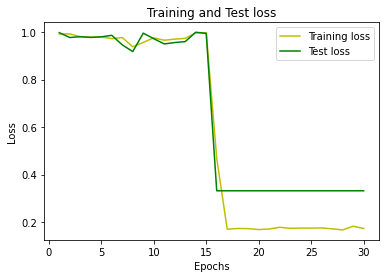

In [51]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Regularized Cross Entropy**

In [52]:
input = Input(shape=(X_train.shape[1],))
x = Flatten()(input)
x = Dense(64, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
dense = Model(input, x)

input1 = Input(shape=(X_train.shape[1],))
input2 = Input(shape=(X_train.shape[1],))
dense1 = dense(input1)
dense2 = dense(input2)

distance = Lambda(euclideanDistance, output_shape=eucl_dist_output_shape)([dense1, dense2])
model = Model([input1, input2], distance)

In [53]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=[accuracy])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 model_9 (Functional)           (None, 256)          90560       ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 lambda_16 (Lambda)             (None, 1)            0           ['model_9[0][0]',         

In [54]:
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=128, epochs=30, validation_data =([pairs_test[:, 0], pairs_test[:, 1]], labels_test))

Epoch 1/30
1618/1618 [==============================] - 8s 4ms/step - loss: 5.9605e-08 - accuracy: 0.5100 - val_loss: 5.9605e-08 - val_accuracy: 0.5484
Epoch 2/30
1618/1618 [==============================] - 7s 4ms/step - loss: 5.9605e-08 - accuracy: 0.5100 - val_loss: 5.9605e-08 - val_accuracy: 0.5484
Epoch 3/30
1618/1618 [==============================] - 7s 4ms/step - loss: 5.9605e-08 - accuracy: 0.5100 - val_loss: 5.9605e-08 - val_accuracy: 0.5484
Epoch 4/30
1618/1618 [==============================] - 7s 4ms/step - loss: 5.9605e-08 - accuracy: 0.5100 - val_loss: 5.9605e-08 - val_accuracy: 0.5484
Epoch 5/30
1618/1618 [==============================] - 7s 4ms/step - loss: 5.9605e-08 - accuracy: 0.5100 - val_loss: 5.9605e-08 - val_accuracy: 0.5484
Epoch 6/30
1618/1618 [==============================] - 7s 4ms/step - loss: 5.9605e-08 - accuracy: 0.5100 - val_loss: 5.9605e-08 - val_accuracy: 0.5484
Epoch 7/30
1618/1618 [==============================] - 7s 4ms/step - loss: 5.9605e-08 -

In [55]:
y_pred_te = model.predict([pairs_test[:, 0], pairs_test[:, 1]])
te_acc = compute_accuracy(labels_test, y_pred_te)

In [56]:
print("Accuracy on test set:", te_acc*100, "%.")

Accuracy on test set: 54.83441571538058 %.


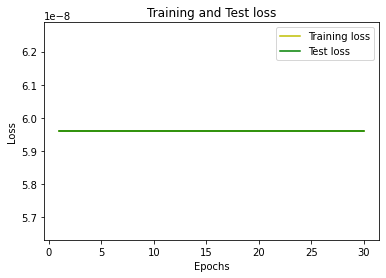

In [57]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history.history['val_accuracy']) + 1))
plt.plot(epochs, loss_values, 'y', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Comparison of Regularized Cross Entropy, Triplet Loss and Contrastive loss functions**

*   Test Accuracy using **Contrastive loss : 74.77%**
*   Test Accuracy using **Triplet Loss : 51.59%**
*   Test Accuracy using **Regularized Cross Entropy : 54.83%**

Hence, **Contrastive loss is the best** among all three loss functions.